# Introduction

This notebook uses a data set from a recent Kaggle competition (https://www.kaggle.com/c/spooky-author-identification) where we are asked to analyze a series of texts and identify them as being written by Mary Shelley, HP Lovecraft, or Edgar Allen Poe. The text snippets are fairly short, so we have to make predictions based on a small number of features per example.

The data set is also quite small, so overfitting is likely to be a problem for many methods. But, it's also small enough to be easy to show various methods in natural language processing. Some things that I show here are:

  - Text analysis with NLTK, GenSim, and Scikit-learn
  - Stop words removal
  - Stemming and Lemmatization
  - One-hot encoding of text (single words and n-grams)
  - Low-dimensional feature encoding with Latent Semantic Analysis and Latent Dirichlet Association
  - Random Forest Classification
  - Term Frequency (TF) matrix
  - Tf-idf weighting
  - Naive Bayes Classification (Multinomial with some code for Bernoulli)

First, we should import some basic libraries that will be useful. While scikit-learn has some NLP classes that I will use later, I will first start out with NLTK and gensim, which are dedicated NLP packages.

In [1]:
import nltk
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

%matplotlib inline

Now, we can read in the files. They are just CSV files, so Pandas is fine. I am also intentionally not setting the ID column so that I can can just use the array index with brackets on a Series. This way I can treat Series objects the same way that I would treat lists, which might simplify some things.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
print('Train length: '+str(len(train['text'])))
print('Test length: '+str(len(test['text'])))
print('Target Distribution: \n'+str(train['author'].value_counts()))

Train length: 19579
Test length: 8392
Target Distribution: 
EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


We can see that about 40% of all entries are from Poe. The data is somewhat imbalanced, so for things like decision trees, we might want to set sample weights to even things out.

# Data Munging

Now, we want to somehow map these texts onto the same space so that we can try to make predictions. First, we'll transform the targets into a numerical encoding.

In [5]:
train_text = train['text']
test_text = test['text']
auth_map = {0:'EAP',1:'HPL',2:'MWS'}
auth_map_inv = {'EAP':0,'HPL':1,'MWS':2}
train_tgt = train['author'].map(auth_map_inv)

### Basic Text Cleaning

The text is from English-language authors, so we can easily just set everything to lowercase and remove punctuation. We will replace all non-alphabetic characters to spaces here.

In [6]:
train_text = [re.sub(r'[^a-z]',' ',text.lower()) for text in train_text]
test_text = [re.sub(r'[^a-z]',' ',text.lower()) for text in test_text]


### Splitting Into Words

Now we should split the text into individual words for further analysis.

In [7]:
all_text = train_text + test_text
all_text = [text.split() for text in all_text]
all_text = [nltk.pos_tag(text) for text in all_text]

### Removing Stop Words

Stop words are very common words that hold little information. Words like "a," "the," "I,", etc. typically don't tell us much about the text, so we can typically remove them to help improve our models. This is perhaps a bit risky here. For example, if one of the authors prefers to use first-person narratives often, removing words like "I," "me," and "my" might hide this. I won't worry about this for now.

For stop words, I will use the standard list from NLTK.

In [8]:
stops = nltk.corpus.stopwords.words('english')
def set_pos(pos):
    if pos[0]=='J':
        return nltk.corpus.wordnet.ADJ
    elif pos[0]=='V':
        return nltk.corpus.wordnet.VERB
    elif pos[0]=='N':
        return nltk.corpus.wordnet.NOUN
    elif pos[0]=='R':
        return nltk.corpus.wordnet.ADV
    return 'n'
    
    
all_text = [ [ (word[0],set_pos(word[1])) for word in text if word[0] not in stops] for text in all_text ]

### Stemming/Lemmatizing

Many words will appear in a number of forms, such as singular and plural nouns, adjectives and adverbs, etc. We can use stemming to try to remove the word endings so that only the "stem" - the part that holds the meaning of the word as opposed to its part of speech. Again, this could actually hurt us if one of the author often uses particular forms of certain words. The Porter stemmer is one example of a fairly common stemmer.

Lemmatization is a more advanced version of stemming that makes use of things like the word part of speech and lists of different words to map one word to another. Unlike with stemming, this will give us a list of real words (rather than often nonsensical stems) to use. I will use the WordNet lemmatizer here.

In [9]:
porter = nltk.stem.porter.PorterStemmer()
wnlemma = nltk.stem.wordnet.WordNetLemmatizer()


all_text = [ [ wnlemma.lemmatize(word[0],pos=nltk.corpus.wordnet.VERB) for word in text] for text in all_text]

### Removing Very Uncommon Words

After this, I am close to my final set of words to use. The last thing I'll do is remove very uncommon words. I'm using methods based on a bag-of-words model, so words that only appear a couple times are probably not going to be that useful. It could be useful to retain these words for methods that are sensitive to word context.

I'll just set a minimum frequency of 3. It would actually probably be better to set a minimum document frequency here, since a single rare word could appear multiple times in a single entry.

In [10]:
min_num = 3

from collections import Counter

counts = Counter()
for text in all_text:
    for word in text:
        counts[word] += 1
to_remove = []
for word in reversed(counts.most_common()):
    if counts[word[0]]<= min_num:
        to_remove.append(word[0])
    else:
        break
print('Total number of words: '+str(len(counts)))
print('Number of words to remove: '+str(len(to_remove)))
#print('Words to remove: \n' + str(to_remove))
all_text = [ [word for word in text if word not in to_remove] for text in all_text]

Total number of words: 21945
Number of words to remove: 12445


We see that in this small data set, about half of all words appear only very rarely. We will be left with a set of around 8000 words to use. We could expand this by using larger n-grams.

## How Many Words Are in Each Entry?

Now that we've cleaned some data, let's see how many words are left in each entry.

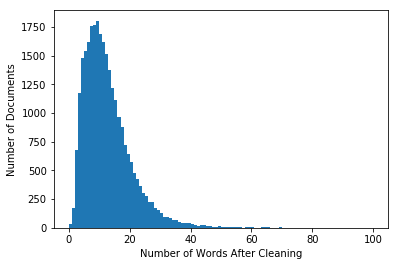

In [11]:
lens = [len(text) for text in all_text]
plt.hist(lens,bins=100,range=(0,100))
plt.xlabel('Number of Words After Cleaning')
plt.ylabel('Number of Documents')
plt.show()

Most of the entries are in the 10-20 word range but there is a long tail. Some documents even have more than 60 words. At any rate, the typical entry has only a small number of features for us to learn.

The last thing that I will do is remove very small entries. I will bring these back when I start training classifiers, but for now, I will remove entries with only one or two remaining words.

In [12]:
minlen = 3
n_to_remove = 0
for text in all_text:
    if len(text)<minlen:
        n_to_remove+=1
        
print('Number of texts smaller than minimum: '+str(n_to_remove) + ' of '+str(len(all_text)))

Number of texts smaller than minimum: 881 of 27971


In [13]:
all_text = [text for text in all_text if len(text)>=minlen]

Only a very small fraction of entries was removed there.

# Representing Entries as Vectors

Now that we have a cleaned data set, we can try to map the text onto a vector space with a fixed number of dimensions. This can be done in a number of packages, but I'll use gensim here.

### Bag of Words Model

First, we can create a dictionary from our text. This allows us to make something like a one-hot encoding of the 8000 or so unique words in our data. This is will give us a bag-of-words model with each document being represented by a sparse vector of term frequencies.

In [14]:
dictionary = gensim.corpora.Dictionary(all_text)
word_vec = [ dictionary.doc2bow(text) for text in all_text ]

### TF-IDF Weighting Scheme

Some of these words are present in many of our documents. These typically have less meaning (or less ability to distinguish entries), so we can generate tf-idf weights. There are various ways to define tf-idf, but they all involve the term frequency (tf) for each document and the inverse of the document frequency (i.e. how many documents the word appears in).

In [15]:
tfidf = gensim.models.TfidfModel(word_vec)
tfidf_vec = [tfidf[vec] for vec in word_vec]


### Vector Encoding/Dimensionality Reduction

One issue with a bag-of-words model, especially when applied to short pieces of text, is that any two entries will have little to no overlap. We can instead try to use the fact that certain words will often appear with similar other words to create smaller-dimensional vectors representing common "topics."

Two common ways to do this are Latent Semantic Analysis (LSA/LSI) and Latent Dirichlet Allocation (LDA). LSA is just doing a singular value decomposition and then usually taking only a subset of entries in the diagonal part. This is more or less the equivalent of PCA for a non-square matrix. I don't know too much about LDA, but it uses a probabilistic model to learn features.

In [16]:
lsi = gensim.models.lsimodel.LsiModel(corpus=tfidf_vec,
                                      id2word=dictionary, 
                                      num_topics=20)

lda = gensim.models.ldamodel.LdaModel(corpus=tfidf_vec,
                                      id2word=dictionary,
                                      num_topics=20,passes=10)
#                                      update_every=1,
#                                      chunksize=5000,
#                                      passes=10)

In [17]:
print('LSA Results')
lsi.print_topics(20)


LSA Results


[(0,
  '0.186*"one" + 0.171*"say" + 0.165*"could" + 0.160*"would" + 0.151*"upon" + 0.140*"know" + 0.117*"come" + 0.116*"see" + 0.114*"make" + 0.111*"time"'),
 (1,
  '-0.789*"say" + -0.235*"know" + 0.207*"upon" + 0.115*"one" + -0.107*"nothing" + 0.091*"eye" + -0.087*"well" + -0.079*"would" + 0.077*"open" + -0.074*"man"'),
 (2,
  '-0.437*"say" + 0.435*"know" + 0.396*"would" + -0.332*"upon" + 0.256*"could" + 0.157*"think" + -0.130*"one" + 0.128*"never" + -0.094*"hand" + 0.087*"see"'),
 (3,
  '-0.482*"know" + 0.381*"would" + 0.301*"could" + -0.251*"come" + -0.201*"go" + -0.174*"old" + -0.126*"night" + -0.104*"see" + 0.102*"think" + 0.101*"upon"'),
 (4,
  '-0.617*"one" + -0.486*"could" + 0.208*"would" + 0.167*"upon" + 0.167*"us" + 0.167*"come" + -0.131*"see" + -0.112*"thing" + 0.108*"must" + 0.106*"let"'),
 (5,
  '-0.559*"one" + 0.422*"could" + 0.294*"upon" + -0.238*"would" + 0.185*"know" + -0.137*"us" + 0.134*"eye" + 0.130*"nothing" + -0.119*"let" + -0.115*"day"'),
 (6,
  '0.446*"upon" + 0

In [18]:
print('LDA Results')
lda.print_topics(20)

LDA Results


[(0,
  '0.006*"whether" + 0.006*"restore" + 0.006*"lady" + 0.005*"also" + 0.005*"mother" + 0.005*"drink" + 0.005*"girl" + 0.004*"joy" + 0.004*"story" + 0.004*"evil"'),
 (1,
  '0.006*"do" + 0.006*"seat" + 0.006*"upon" + 0.005*"happen" + 0.005*"better" + 0.005*"danger" + 0.005*"chair" + 0.005*"accident" + 0.005*"board" + 0.005*"avoid"'),
 (2,
  '0.008*"lord" + 0.007*"departure" + 0.007*"want" + 0.007*"ryland" + 0.006*"earnest" + 0.006*"plague" + 0.006*"noon" + 0.006*"enemy" + 0.006*"solitude" + 0.006*"aid"'),
 (3,
  '0.008*"love" + 0.006*"would" + 0.006*"happy" + 0.006*"feel" + 0.005*"hope" + 0.005*"say" + 0.005*"heart" + 0.005*"raymond" + 0.005*"felt" + 0.004*"regard"'),
 (4,
  '0.010*"hasten" + 0.009*"shake" + 0.008*"summer" + 0.007*"winter" + 0.006*"tale" + 0.006*"request" + 0.006*"future" + 0.006*"sick" + 0.006*"positive" + 0.006*"examine"'),
 (5,
  '0.005*"would" + 0.005*"die" + 0.005*"come" + 0.005*"arrive" + 0.005*"wonder" + 0.005*"walk" + 0.005*"dare" + 0.005*"dark" + 0.004*"sist

# Preparing the Training and Test Sets

The work we did previously is all data munging and unsupervised training on the full (training and test) data set. Now, we should repeat our work separately for the training and test sets. We could just split the combined array back into two, but it's nicer to package our work into a single short function.

In [21]:
# mod gives the mapping from tfidf to the 50-feature space
def prepare_text(data,mod):
    data = [re.sub(r'[^a-z]',' ',text.lower()) for text in data]
    data = [text.split() for text in data]
    data = [nltk.pos_tag(text) for text in data]
    data = [ [ (word[0],set_pos(word[1])) for word in 
                  text if word[0] not in stops] for text in data ]
    data = [ [ wnlemma.lemmatize(word[0],pos=nltk.corpus.wordnet.VERB) 
              for word in text] for text in data]
    data = [dictionary.doc2bow(text) for text in data]
    data = [tfidf[text] for text in data ]
    data = [mod[text] for text in data]

    data_arr = []
    for text in data:
        data_arr.append([0.]*20)
        for word in text:
            data_arr[-1][word[0]] = word[1]

    return np.array(data_arr)

Now, we can run on the training and test sets using the LSA model.

In [31]:
train_prep = prepare_text(train_text,lda)
test_prep = prepare_text(test_text,lda)

# kNN Classification

The first method that we will try is a kNN classification. We've reduced our large feature set to a much smaller encoding, so now we can try to classify texts by the labels of nearby texts.

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
pars = {'p':[1],'n_neighbors':[15,25,50]}
gcv = GridSearchCV(knn,param_grid=pars,scoring='neg_log_loss',cv=5)
gcv.fit(train_prep,np.array(train_tgt))

print(gcv.best_params_)
print(gcv.cv_results_['mean_test_score'])
print(gcv.cv_results_['mean_train_score'])

{'n_neighbors': 50, 'p': 1}
[-1.20793729 -0.95449827 -0.8871786 ]
[-0.76359443 -0.80050618 -0.83610568]


# Running a Random Forest Classifier

A Random Forest is a fairly straightforward type of classifier. We use the 50 features of our encoding as inputs and try to predict which of the three authors wrote which text.

In [26]:
from sklearn.ensemble import RandomForestClassifier


# Get class weights: The data set is imbalanced

weights = np.max(train_tgt.value_counts())/train_tgt.value_counts()
print(weights)

c_weight = {}
for i in range(len(weights)):
    c_weight[weights.index[i]] = weights[i]
    
# This is just the same as scoring='neg_log_loss'
logloss_score = metrics.make_scorer(metrics.log_loss,needs_proba=True,greater_is_better=False)

# Random forest with some random params
rfc = RandomForestClassifier(max_depth=10,min_samples_leaf=10,n_estimators=50,
                             class_weight=c_weight)

# Cross validate
scores = cross_validate(rfc,train_prep,np.array(train_tgt),cv=5,
                        scoring=logloss_score)
scores

0    1.000000
2    1.307081
1    1.401952
Name: author, dtype: float64


{'fit_time': array([ 1.96204352,  1.92350149,  1.93846989,  1.98561382,  1.88812733]),
 'score_time': array([ 0.02696228,  0.02624106,  0.02706885,  0.02936625,  0.02635312]),
 'test_score': array([-0.87514703, -0.86338331, -0.8542745 , -0.86460545, -0.86673577]),
 'train_score': array([-0.71751604, -0.72417811, -0.72447394, -0.72236722, -0.72170626])}

In [29]:
pars = {'max_depth':[15,None],'min_samples_leaf':[2,5,10],'n_estimators':[50]}
gcv = GridSearchCV(rfc,param_grid=pars,scoring=logloss_score,cv=5)
gcv.fit(train_prep,np.array(train_tgt))


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 1.0, 2: 1.401952085181899, 1: 1.3070814030443414},
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [15, None], 'min_samples_leaf': [2, 5, 10], 'n_estimators': [50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
       verbose=0)

In [30]:
print(gcv.best_params_)
print(gcv.cv_results_['mean_test_score'])
print(gcv.cv_results_['mean_train_score'])

{'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 50}
[-0.84725913 -0.84823735 -0.85391937 -0.85712546 -0.84881893 -0.85293451]
[-0.3874443  -0.52536579 -0.64057104 -0.31958367 -0.50485568 -0.63549075]


We see that, at least without heavily tuning the different parameters of the model, we can do better than just guessing Poe for everything, but we still only get around 60% correct if we look at the equivalent accuracy scores. Furthermore, this model is quite slow. 

Why might this approach not work too well? First, as I already said, this analysis is not optimized very well. Perhaps there is some combination of parameters that works much better. It might take a long time to find those parameters if they do exist. We could also try other methods such as neural nets or boosted decision trees, but we'll have to be very careful about overtraining. More importantly, we're trying to cluster short pieces of text into individual topics. However, these authors all wrote works with similar themes in English in the 1800s and (for Lovecraft) early 1900s. It may simply be that many of the topics that we've found appear in the works of all three. It also may be that the texts are simply too short to get a good encoding of the topic. So, are there any better ways to analyze our data?

# Naive Bayes Classification

A naive Bayes classifier might do much better here. It will certainly do a better job at catching words that are particularly favored by one of the authors. It can also try to find the relative weights of the different authors even on the unlabeled test set.

### Document Term Frequency Matrix

For this set, we will want to run a multinomial naive Bayes classifier on the term frequency matrix. The CountVectorizer in Scikit-learn is an easy way to generate a Scikit-learn-friendly term frequency matrix. We can also choose the range of n-grams to use and the minimum document frequency. I'll just set some numbers here. I'm still using the text after removing stop words and running the stemming algorithm, so it's likely that things like 3-grams are usually unique to a single document. It's quite likely that the data munging can be better tuned to this model.

In [97]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
all_text_joined = [ ' '.join(text) for text in all_text]

cvec = CountVectorizer(ngram_range=(1,3),min_df=2)
cvec.fit(all_text_joined)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### Preparing the Training and Test Sets

As before, I'll package all the work into a short script to process the separate test and training sets.

In [98]:


def prepare_text_counts(data):
    data = [re.sub(r'[^a-z]',' ',text.lower()) for text in data]
    data = [text.split() for text in data]
    data = [nltk.pos_tag(text) for text in data]
    data = [ [ (word[0],set_pos(word[1])) for word in 
                  text if word[0] not in stops] for text in data ]
    data = [ [ wnlemma().lemmatize(word[0],pos=nltk.corpus.wordnet.VERB) 
              for word in text] for text in data]
    data = [ ' '.join(text) for text in data]
    data = cvec.transform(data)
    return data
    
    

In [99]:
train_text = train['text']
test_text = test['text']
train_prep = prepare_text_counts(train_text)
test_prep = prepare_text_counts(test_text)

### Running the Multinomial NB Model

There aren't too many options for the Scikit-learn naive Bayes model. I will optimize the smoothing parameter alpha, and use the default options for the others. Thus, this model will try to fit for the prior probabilities for the different authors (i.e. the relative normalizations).

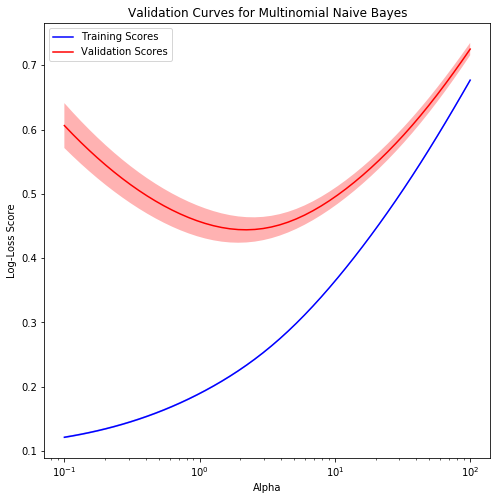

In [100]:
from sklearn.model_selection import validation_curve

mnb = MultinomialNB(alpha=1)
bnb = BernoulliNB(alpha=1,binarize=0.5)
vals = np.logspace(-1,2,50)
#vals = np.logspace(-1,0.3,50)
train_scores,valid_scores = validation_curve(mnb,train_prep,
                                             np.array(train_tgt),'alpha',
                                             vals,cv=10,scoring=logloss_score)

train_mean = -np.mean(train_scores,axis=1)
valid_mean = -np.mean(valid_scores,axis=1)
train_std = np.std(train_scores,axis=1)
valid_std = np.std(valid_scores,axis=1)

fig = plt.figure(1,(8,8))
plt.plot(vals,train_mean,color='b',label='Training Scores')
plt.fill_between(vals,train_mean-train_std,train_mean+train_std,facecolor='b',alpha=0.3)

plt.plot(vals,valid_mean,color='r',label='Validation Scores')
plt.fill_between(vals,valid_mean-valid_std,valid_mean+valid_std,facecolor='r',alpha=0.3)

plt.legend()
plt.ylabel('Log-Loss Score')
plt.xlabel('Alpha')
plt.xscale('log')
plt.title('Validation Curves for Multinomial Naive Bayes')
plt.show()

We immediately see that the NB model is doing much better than the Random Forest even without doing any tuning. It's possible that a Random Forest using the TF matrix or TF-IDF matrix might outperform the NB model. I've tried doing some tests with a normalized TF matrix using a Random Forest but did not get any promising results for the different parameters that I tried. The NB also runs much faster. We get an optimum alpha of around 2 here, with a log-loss score of around 0.45. This is roughly an accuracy of 80%, as opposed to around 60% for our initial Random Forest model.